# NeurIPS_Open-Polymer-Prediction-2025

### Goal 
Predicting polymer properties with machine learning to accelerate sustainable materials research.

### Data
In this competition, your task is to use polymer structure data (SMILES) to predict five key chemical properties derived from molecular dynamics simulation: glass transition temperature (Tg), fractional free volume (FFV), thermal conductivity (Tc), polymer density, and radius of gyration (Rg). Successfully predicting these properties is crucial for scientists to accelerate the design of novel polymers with targeted characteristics, which can be used in various applications.

In [2]:
#import
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, DataStructs, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate,cross_val_score, KFold
import optuna

In [3]:
def smiles_to_fingerprint(smiles, radius=3, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [4]:
def visualize_bit_substructures(smiles_list, bit_position, radius=3, n_bits=2048, mols_per_row=6):
    valid_mols = []
    valid_smiles = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Invalid SMILES skipped: {smiles}")
            continue
        fp_array = smiles_to_fingerprint(smiles, radius, n_bits)
        if fp_array is not None and fp_array[bit_position] == 1:
            valid_mols.append(mol)
            valid_smiles.append(smiles)
    if not valid_mols:
        print(f"No molecules in the list have bit {bit_position} set")
        return
    
    n_mols = len(valid_mols)
    n_rows = math.ceil(n_mols / mols_per_row)
    fig, axs = plt.subplots(n_rows, mols_per_row, 
                           figsize=(4*mols_per_row, 4*n_rows),
                           squeeze=False)
    axs = axs.flatten()
    for i, (mol, smiles) in enumerate(zip(valid_mols, valid_smiles)):
        ax = axs[i]

        bitInfo = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(
            mol, radius=radius, nBits=n_bits, bitInfo=bitInfo)
        
        atom_infos = bitInfo[bit_position]
        highlight_atoms = set()
        highlight_bonds = set()
        
        for atom_idx, env_radius in atom_infos:
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, env_radius, atom_idx)
            highlight_bonds.update(env)
            for bond_idx in env:
                bond = mol.GetBondWithIdx(bond_idx)
                highlight_atoms.add(bond.GetBeginAtomIdx())
                highlight_atoms.add(bond.GetEndAtomIdx())
        
        drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
        rdMolDraw2D.PrepareAndDrawMolecule(
            drawer, mol, 
            highlightAtoms=list(highlight_atoms),
            highlightBonds=list(highlight_bonds),
            highlightAtomColors={idx: (0.8, 0.8, 0.8) for idx in highlight_atoms},
            highlightBondColors={idx: (0.8, 0.8, 0.8) for idx in highlight_bonds}
        )
        drawer.FinishDrawing()
        img = Image.open(io.BytesIO(drawer.GetDrawingText()))
        ax.imshow(img)
        ax.set_title(f"{smiles[:15]}...\nBit {bit_position}", fontsize=10)
        ax.axis('off')
        
    for j in range(i+1, len(axs)):
        axs[j].axis('off')
    plt.tight_layout()
    plt.show()

In [35]:
data =pd.read_csv("Feature_train.csv")

### FFV

In [36]:
ffv = data.drop(["id","SMILES","Tc","Density","Rg","Tg"],axis=1)
ffv.dropna(subset=['FFV'],inplace=True)

In [37]:
ffv.replace([np.inf, -np.inf], np.nan, inplace=True)
ffv.fillna(ffv.mean(), inplace=True) 

In [38]:
import re
des = [col for col in ffv.columns if not re.search(r'\d', col)]
des.extend([col for col in ffv.columns if re.search(r'\d', col)][2049:])
des.extend([[col for col in ffv.columns if re.search(r'\d', col)][0]])
fp = [col for col in ffv.columns if col not in des]

In [39]:
for i in des:
    scaler = MinMaxScaler()
    ffv[i] = scaler.fit_transform(ffv[i].values.reshape(-1, 1)).ravel()

C:\Users\shasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning:

All-NaN slice encountered

C:\Users\shasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning:

All-NaN slice encountered

C:\Users\shasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning:

All-NaN slice encountered

C:\Users\shasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning:

All-NaN slice encountered

C:\Users\shasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning:

All-NaN slice encountered

C:\Users\shasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning:

All-NaN slice encountered

C:\Users\shasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\p

In [40]:
X = ffv.drop(["FFV"],axis=1)
y =ffv["FFV"]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'}

cv_results = cross_validate(model, X_train,y_train, cv=cv,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True )

train_rmse_mean = -cv_results['train_rmse'].mean()
train_rmse_std = cv_results['train_rmse'].std()
train_r2_mean = cv_results['train_r2'].mean()
train_r2_std = cv_results['train_r2'].std()
test_rmse_mean = -cv_results['test_rmse'].mean()
test_rmse_std = cv_results['test_rmse'].std()
test_r2_mean = cv_results['test_r2'].mean()
test_r2_std = cv_results['test_r2'].std()

print("Cross-Validation Performance:")
print(f"Training RMSE: {train_rmse_mean:.4f} (±{train_rmse_std:.4f})")
print(f"Training R²: {train_r2_mean:.4f} (±{train_r2_std:.4f})")
print(f"Validation RMSE: {test_rmse_mean:.4f} (±{test_rmse_std:.4f})")
print(f"Validation R²: {test_r2_mean:.4f} (±{test_r2_std:.4f})\n")

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Final Test Performance:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Cross-Validation Performance:
Training RMSE: 0.0009 (±0.0000)
Training R²: 0.9997 (±0.0000)
Validation RMSE: 0.0234 (±0.0054)
Validation R²: 0.8021 (±0.0801)

Final Test Performance:
RMSE: 0.0199
R²: 0.8735


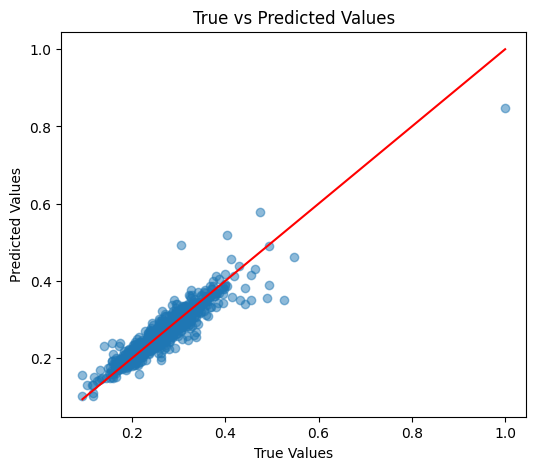

In [43]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

#### Hyperparameter Optimization

In [44]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 20, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "gamma": trial.suggest_float("gamma", 0, 5, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step=1),
    }
    model = xgb.XGBRegressor(**param, objective='reg:squarederror', random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    return scores.mean()

In [45]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(f"  Best R² (CV): {study.best_trial.value:.4f}")
print(f"  Params: {study.best_trial.params}")

best_params = study.best_trial.params
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)

print(f"\nTest R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")

[I 2025-08-15 19:18:42,518] A new study created in memory with name: no-name-25a71efb-e434-4732-8b22-d4da7037a2cb
[I 2025-08-15 19:18:56,055] Trial 0 finished with value: -0.001064981167050405 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.04, 'gamma': 2.2, 'min_child_weight': 2}. Best is trial 0 with value: -0.001064981167050405.
[I 2025-08-15 19:19:36,609] Trial 1 finished with value: -0.001064981167050405 and parameters: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.27, 'gamma': 1.7000000000000002, 'min_child_weight': 9}. Best is trial 0 with value: -0.001064981167050405.
[I 2025-08-15 19:20:07,710] Trial 2 finished with value: -0.001064981167050405 and parameters: {'n_estimators': 350, 'max_depth': 20, 'learning_rate': 0.13, 'gamma': 4.4, 'min_child_weight': 7}. Best is trial 0 with value: -0.001064981167050405.
[I 2025-08-15 19:20:36,017] Trial 3 finished with value: -0.001064981167050405 and parameters: {'n_estimators': 300, 'max_depth': 8, '

Best trial:
  Best R² (CV): 0.7729
  Params: {'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.05, 'gamma': 0.0, 'min_child_weight': 3}

Test R²: 0.8623
Test MSE: 0.0004


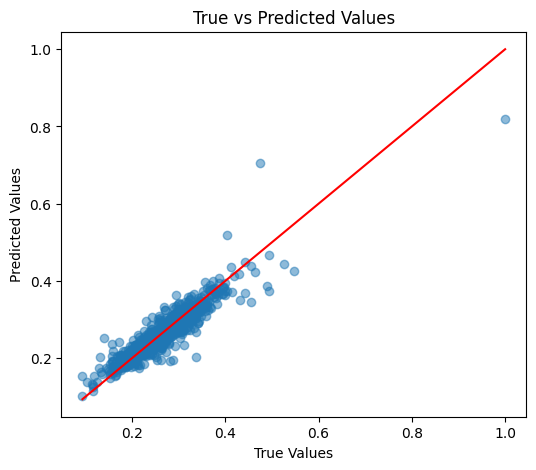

In [56]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

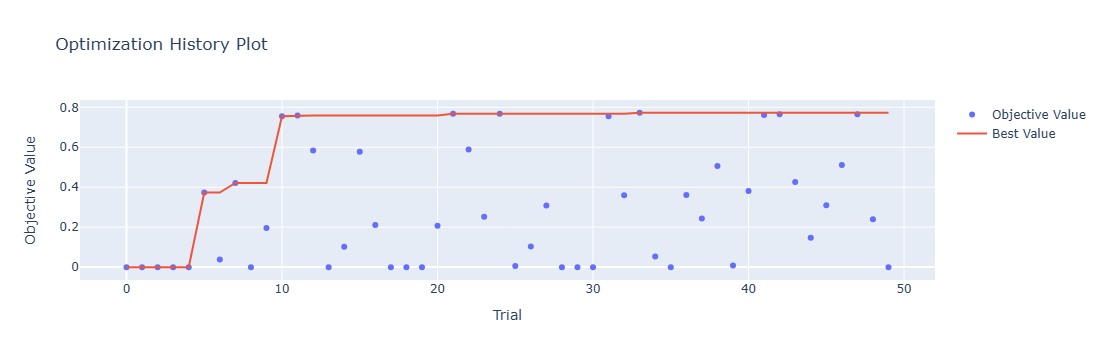

In [46]:
optuna.visualization.plot_optimization_history(study).show()

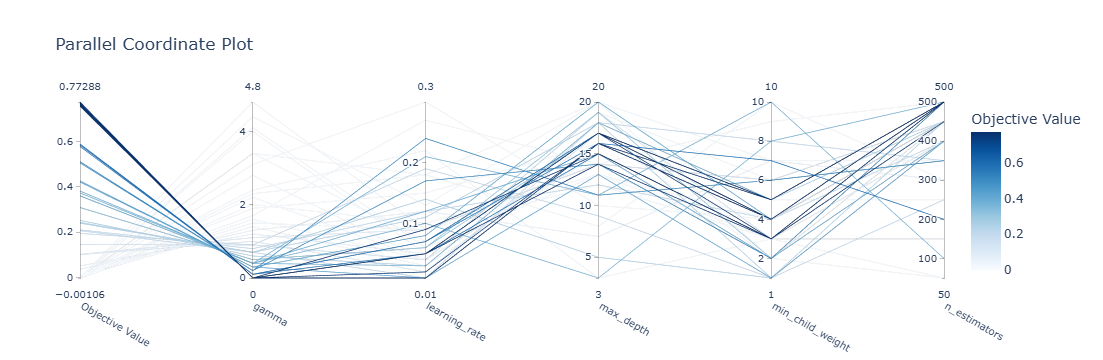

In [47]:
optuna.visualization.plot_parallel_coordinate(study).show()

##### Top 20 features

<BarContainer object of 20 artists>

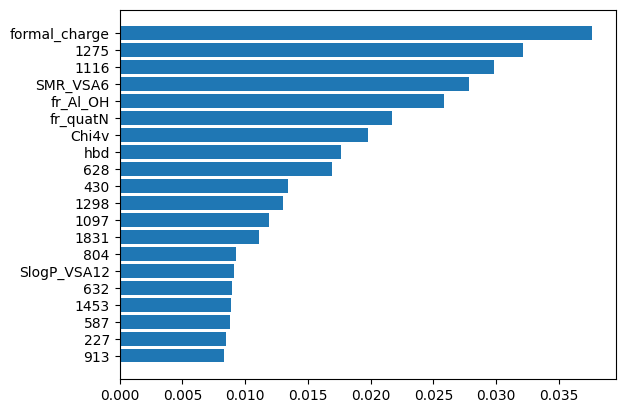

In [48]:
idx = best_model.feature_importances_.argsort()
plt.barh(X_train.columns[idx][2256:2276],best_model.feature_importances_[idx][2256:2276])

#### SHAP

In [49]:
import shap

In [50]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)

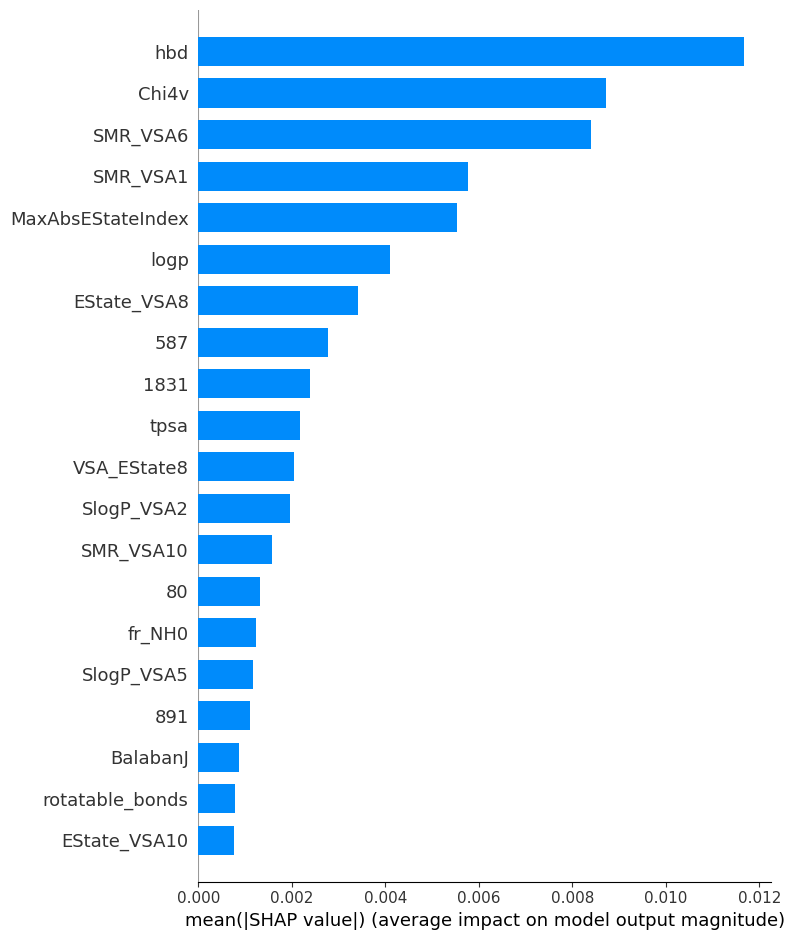

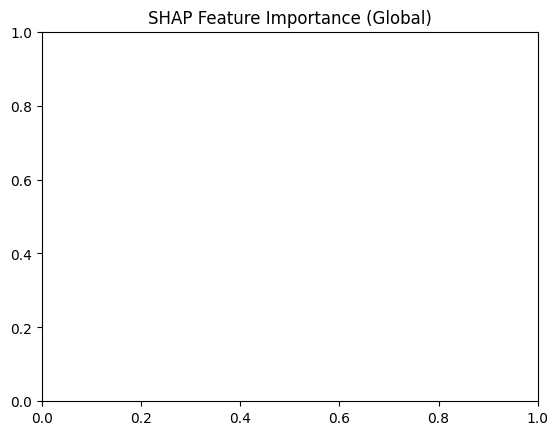

In [51]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.title("SHAP Feature Importance (Global)")
plt.show()

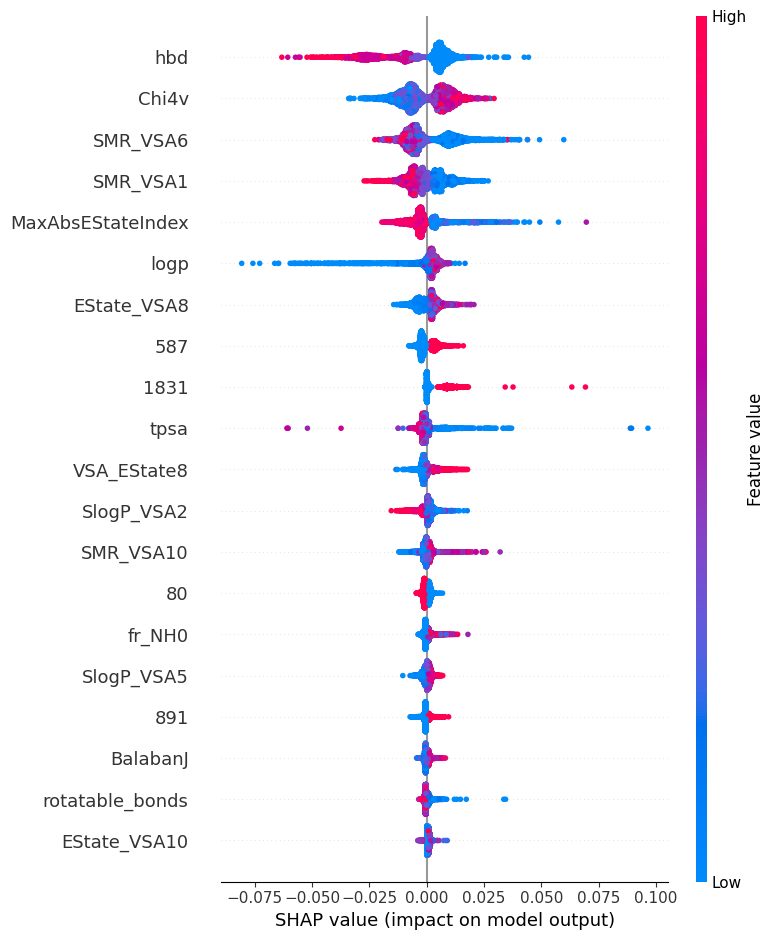

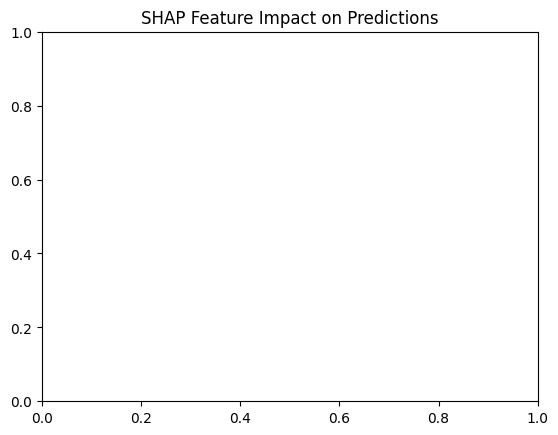

In [52]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train)
plt.title("SHAP Feature Impact on Predictions")
plt.show()

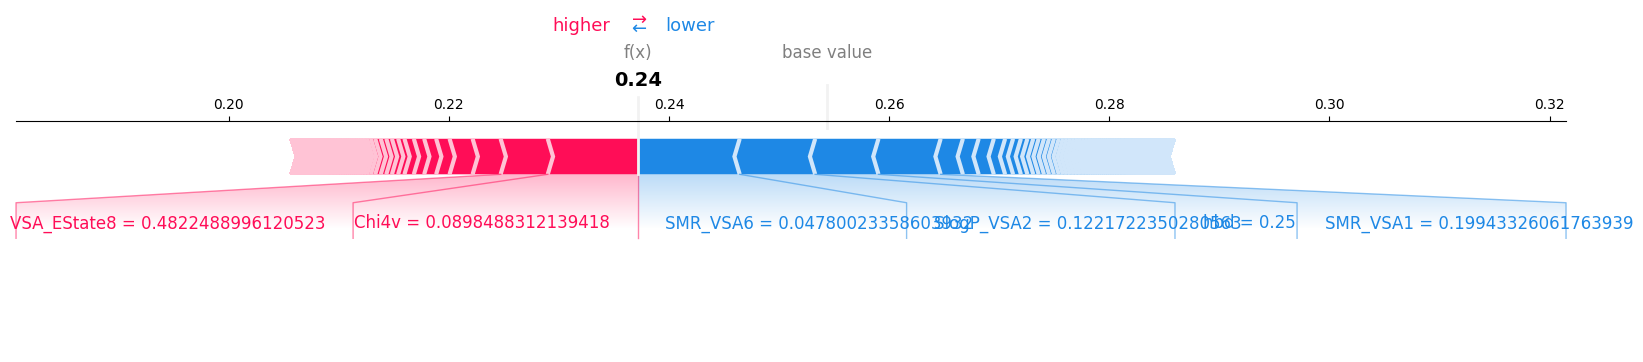

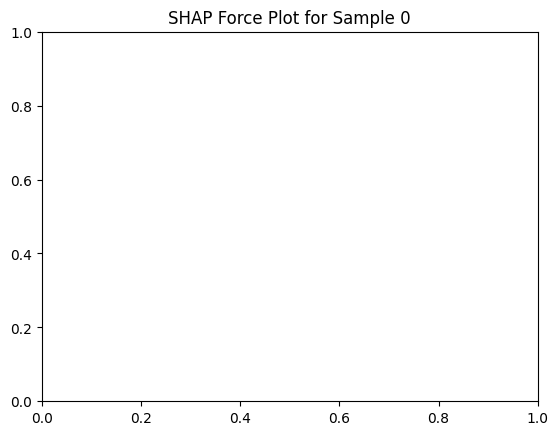

In [53]:
sample_idx = 0
shap.force_plot(
    explainer.expected_value,
    shap_values.values[sample_idx, :],
    X_train.iloc[sample_idx, :],
    matplotlib=True,
)
plt.title(f"SHAP Force Plot for Sample {sample_idx}")
plt.show()

#### Sub structure visualization

[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerator
[14:21:32] DEPRECATION WARNING: please use MorganGenerat

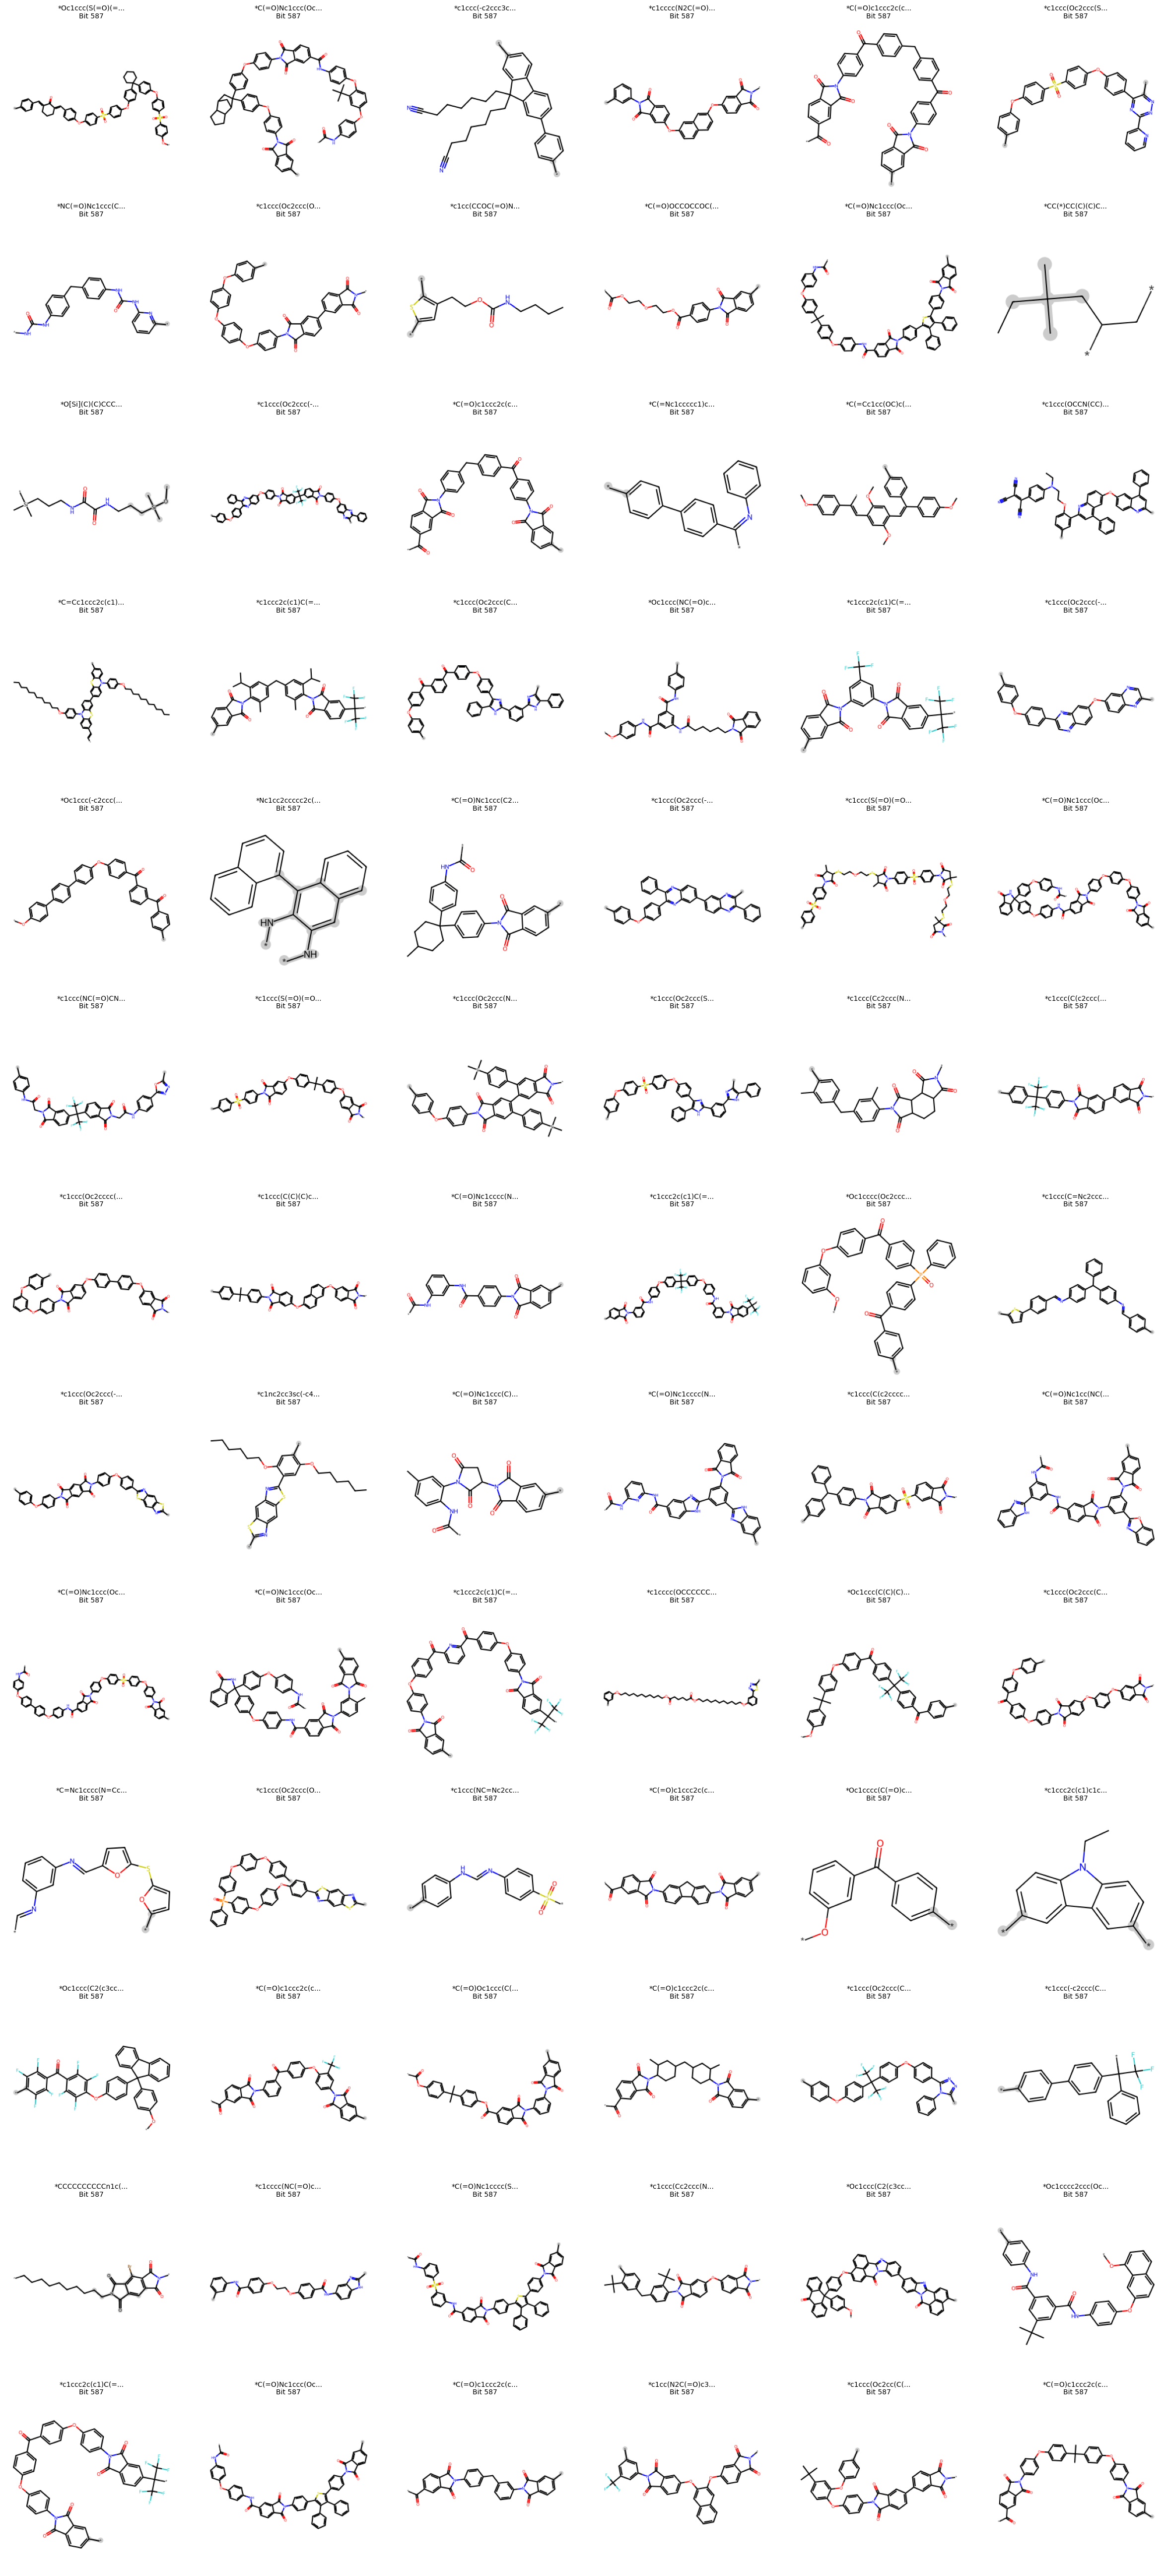

In [32]:
smiles_list = data["SMILES"].to_list()[:200]
visualize_bit_substructures(smiles_list, bit_position=587) #polymerization point

[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerator
[14:21:40] DEPRECATION WARNING: please use MorganGenerat

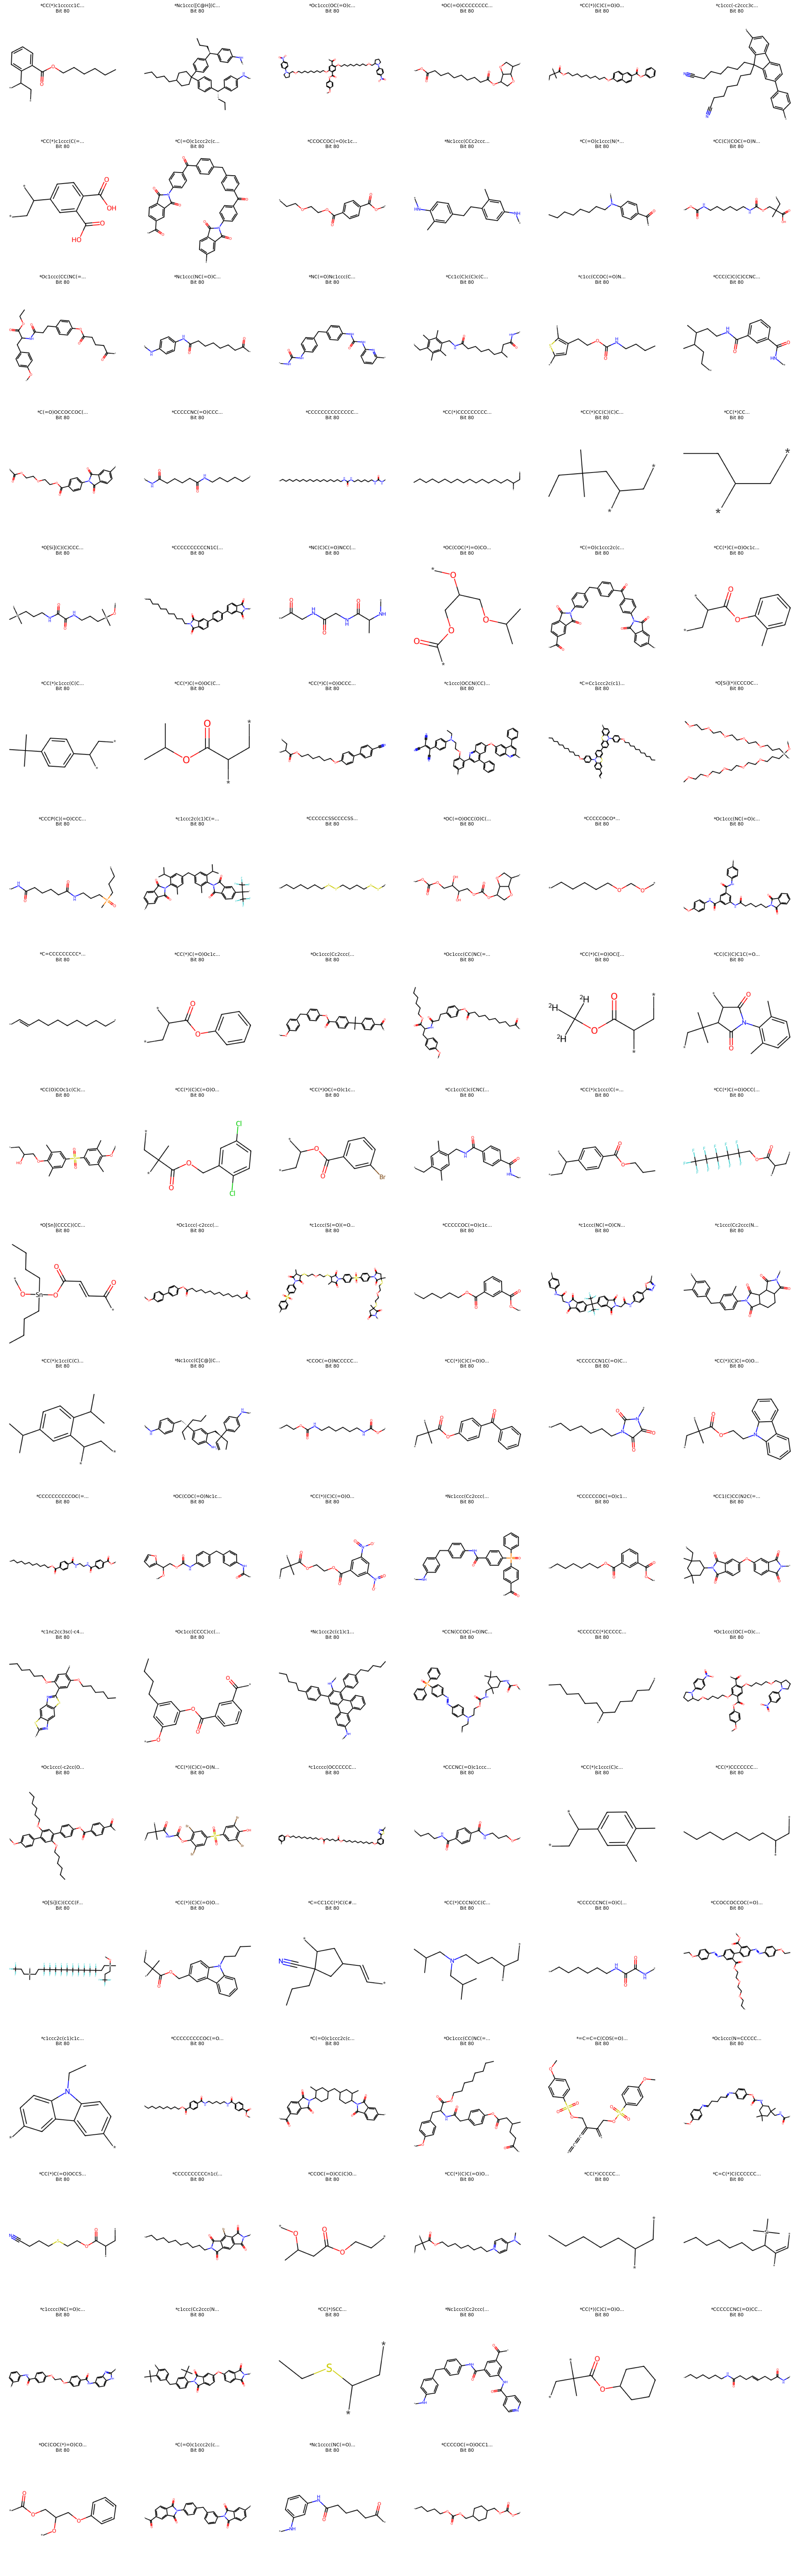

In [33]:
smiles_list = data["SMILES"].to_list()[:200]
visualize_bit_substructures(smiles_list, bit_position=80) #c-o-c-c-c-o-c-c

[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerator
[14:21:50] DEPRECATION WARNING: please use MorganGenerat

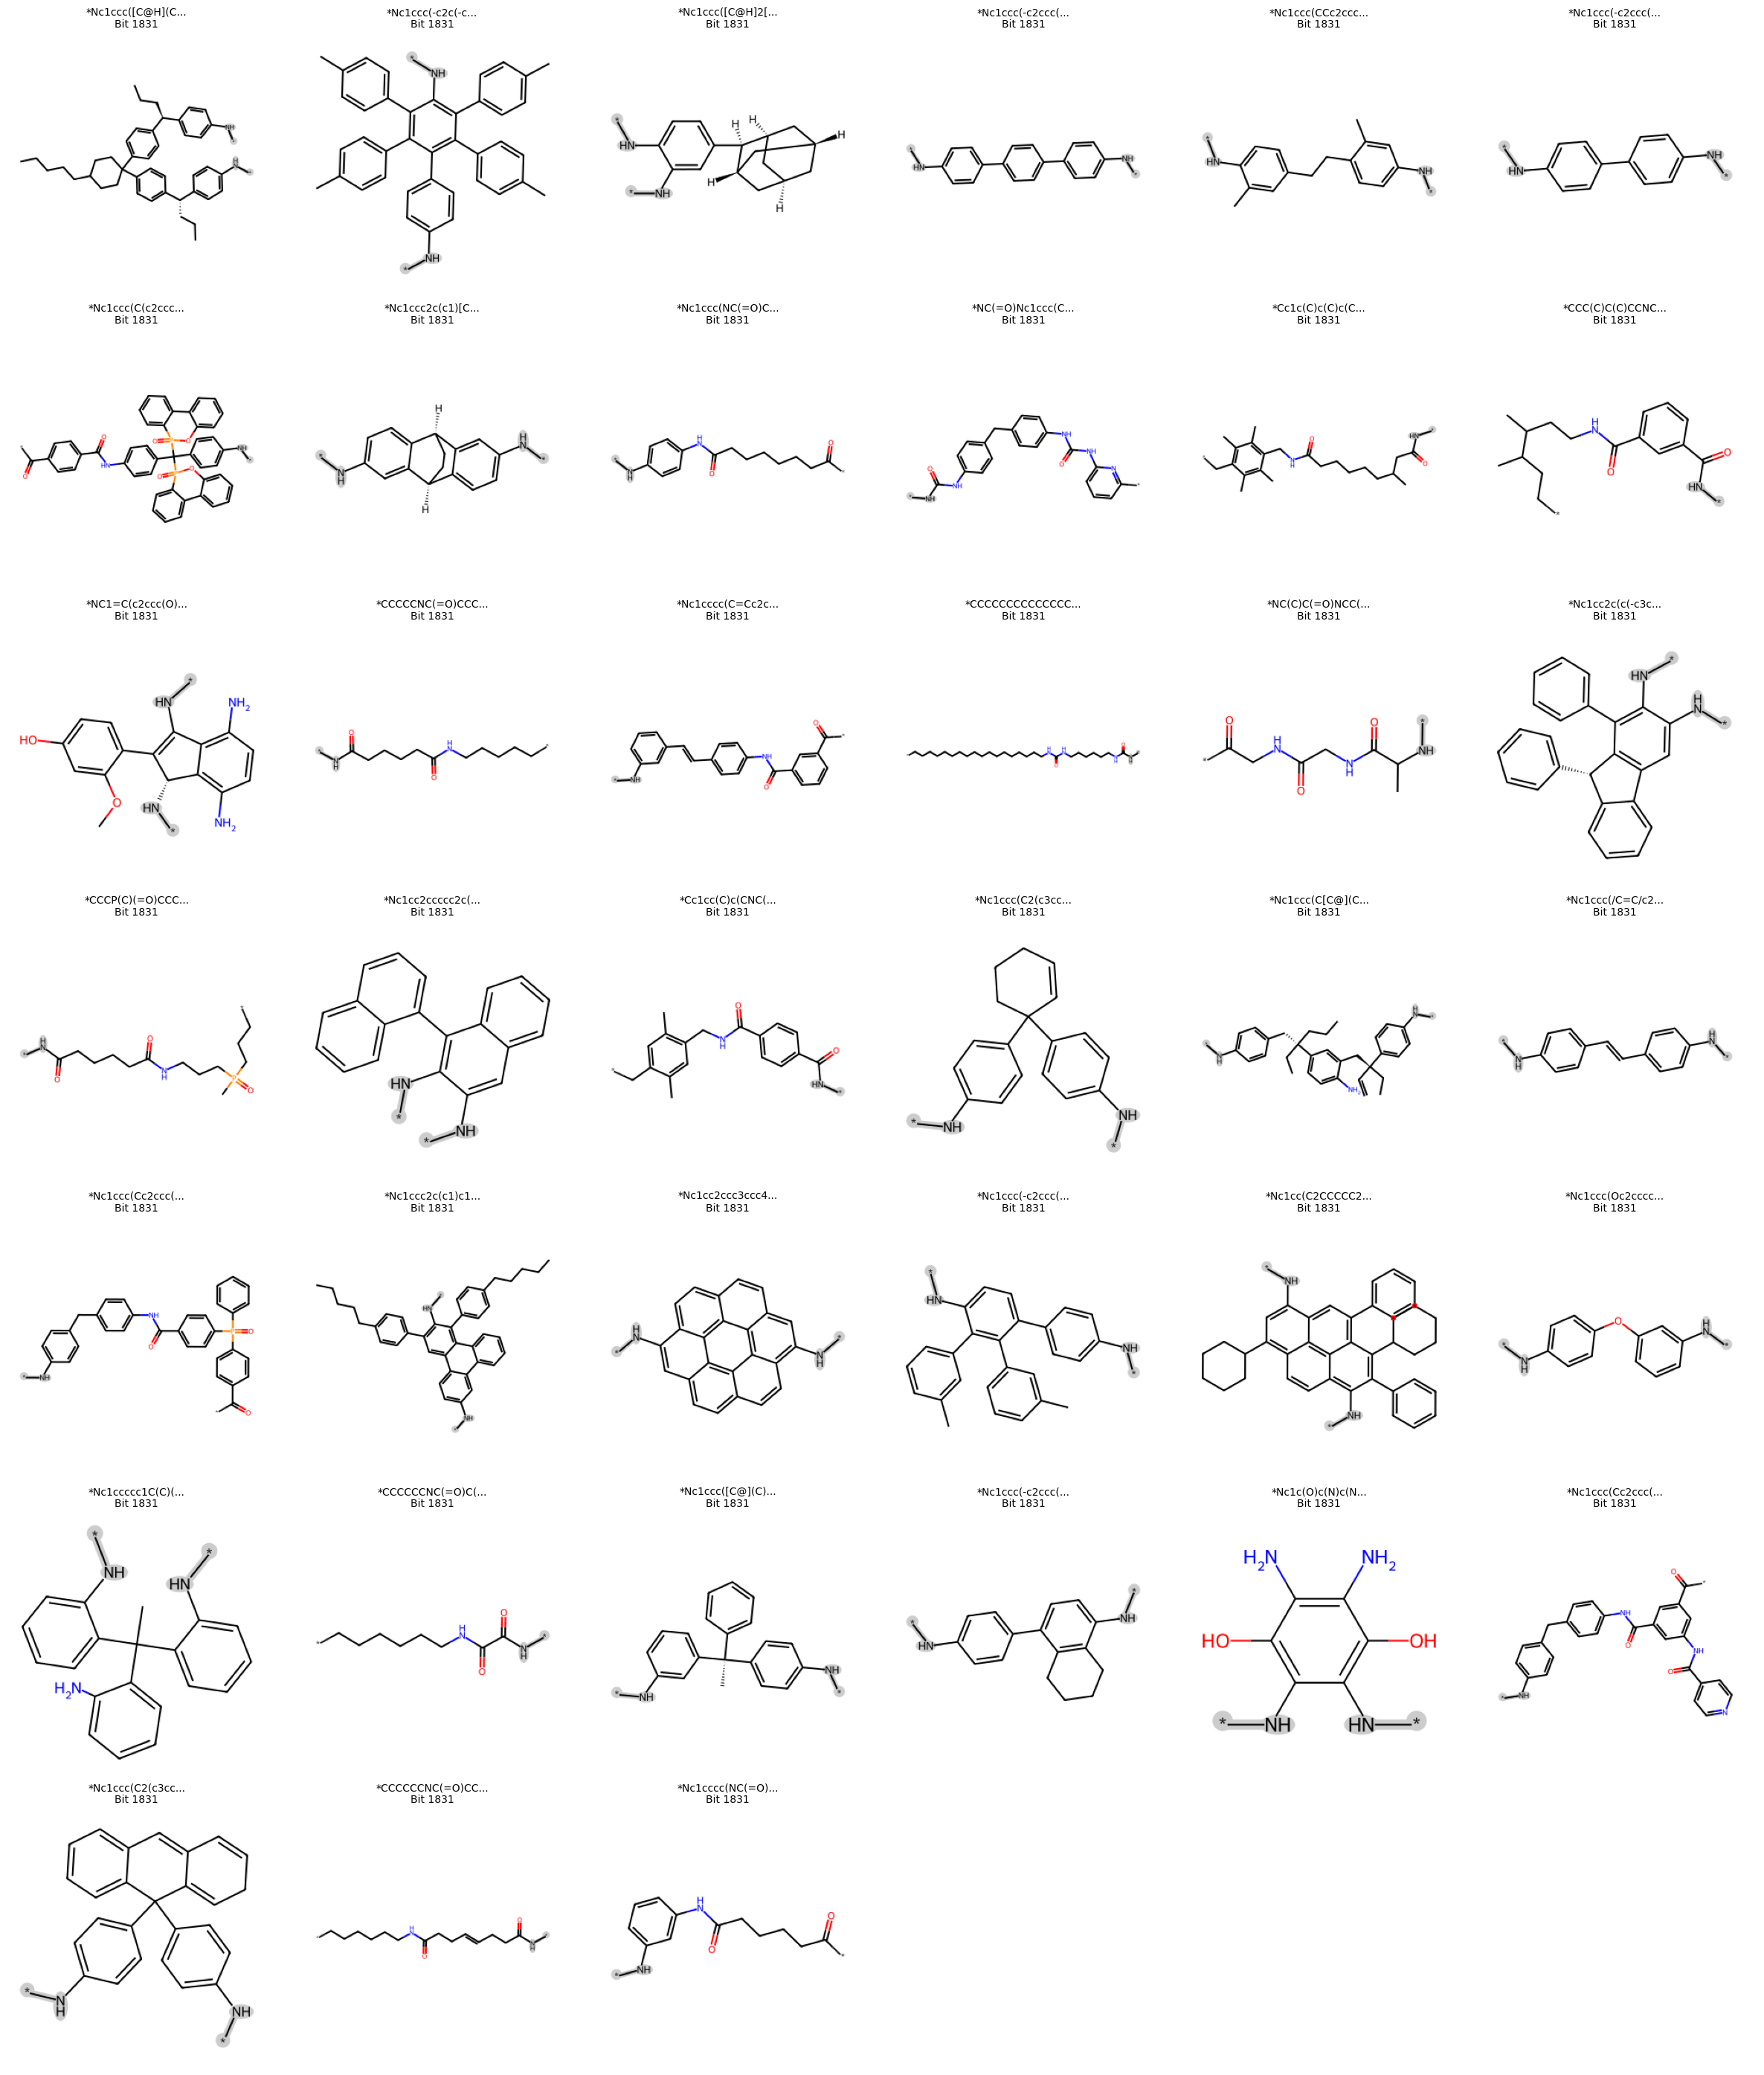

In [34]:
smiles_list = data["SMILES"].to_list()[:200]
visualize_bit_substructures(smiles_list, bit_position=1831) #NH-*

[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerator
[21:01:52] DEPRECATION WARNING: please use MorganGenerat

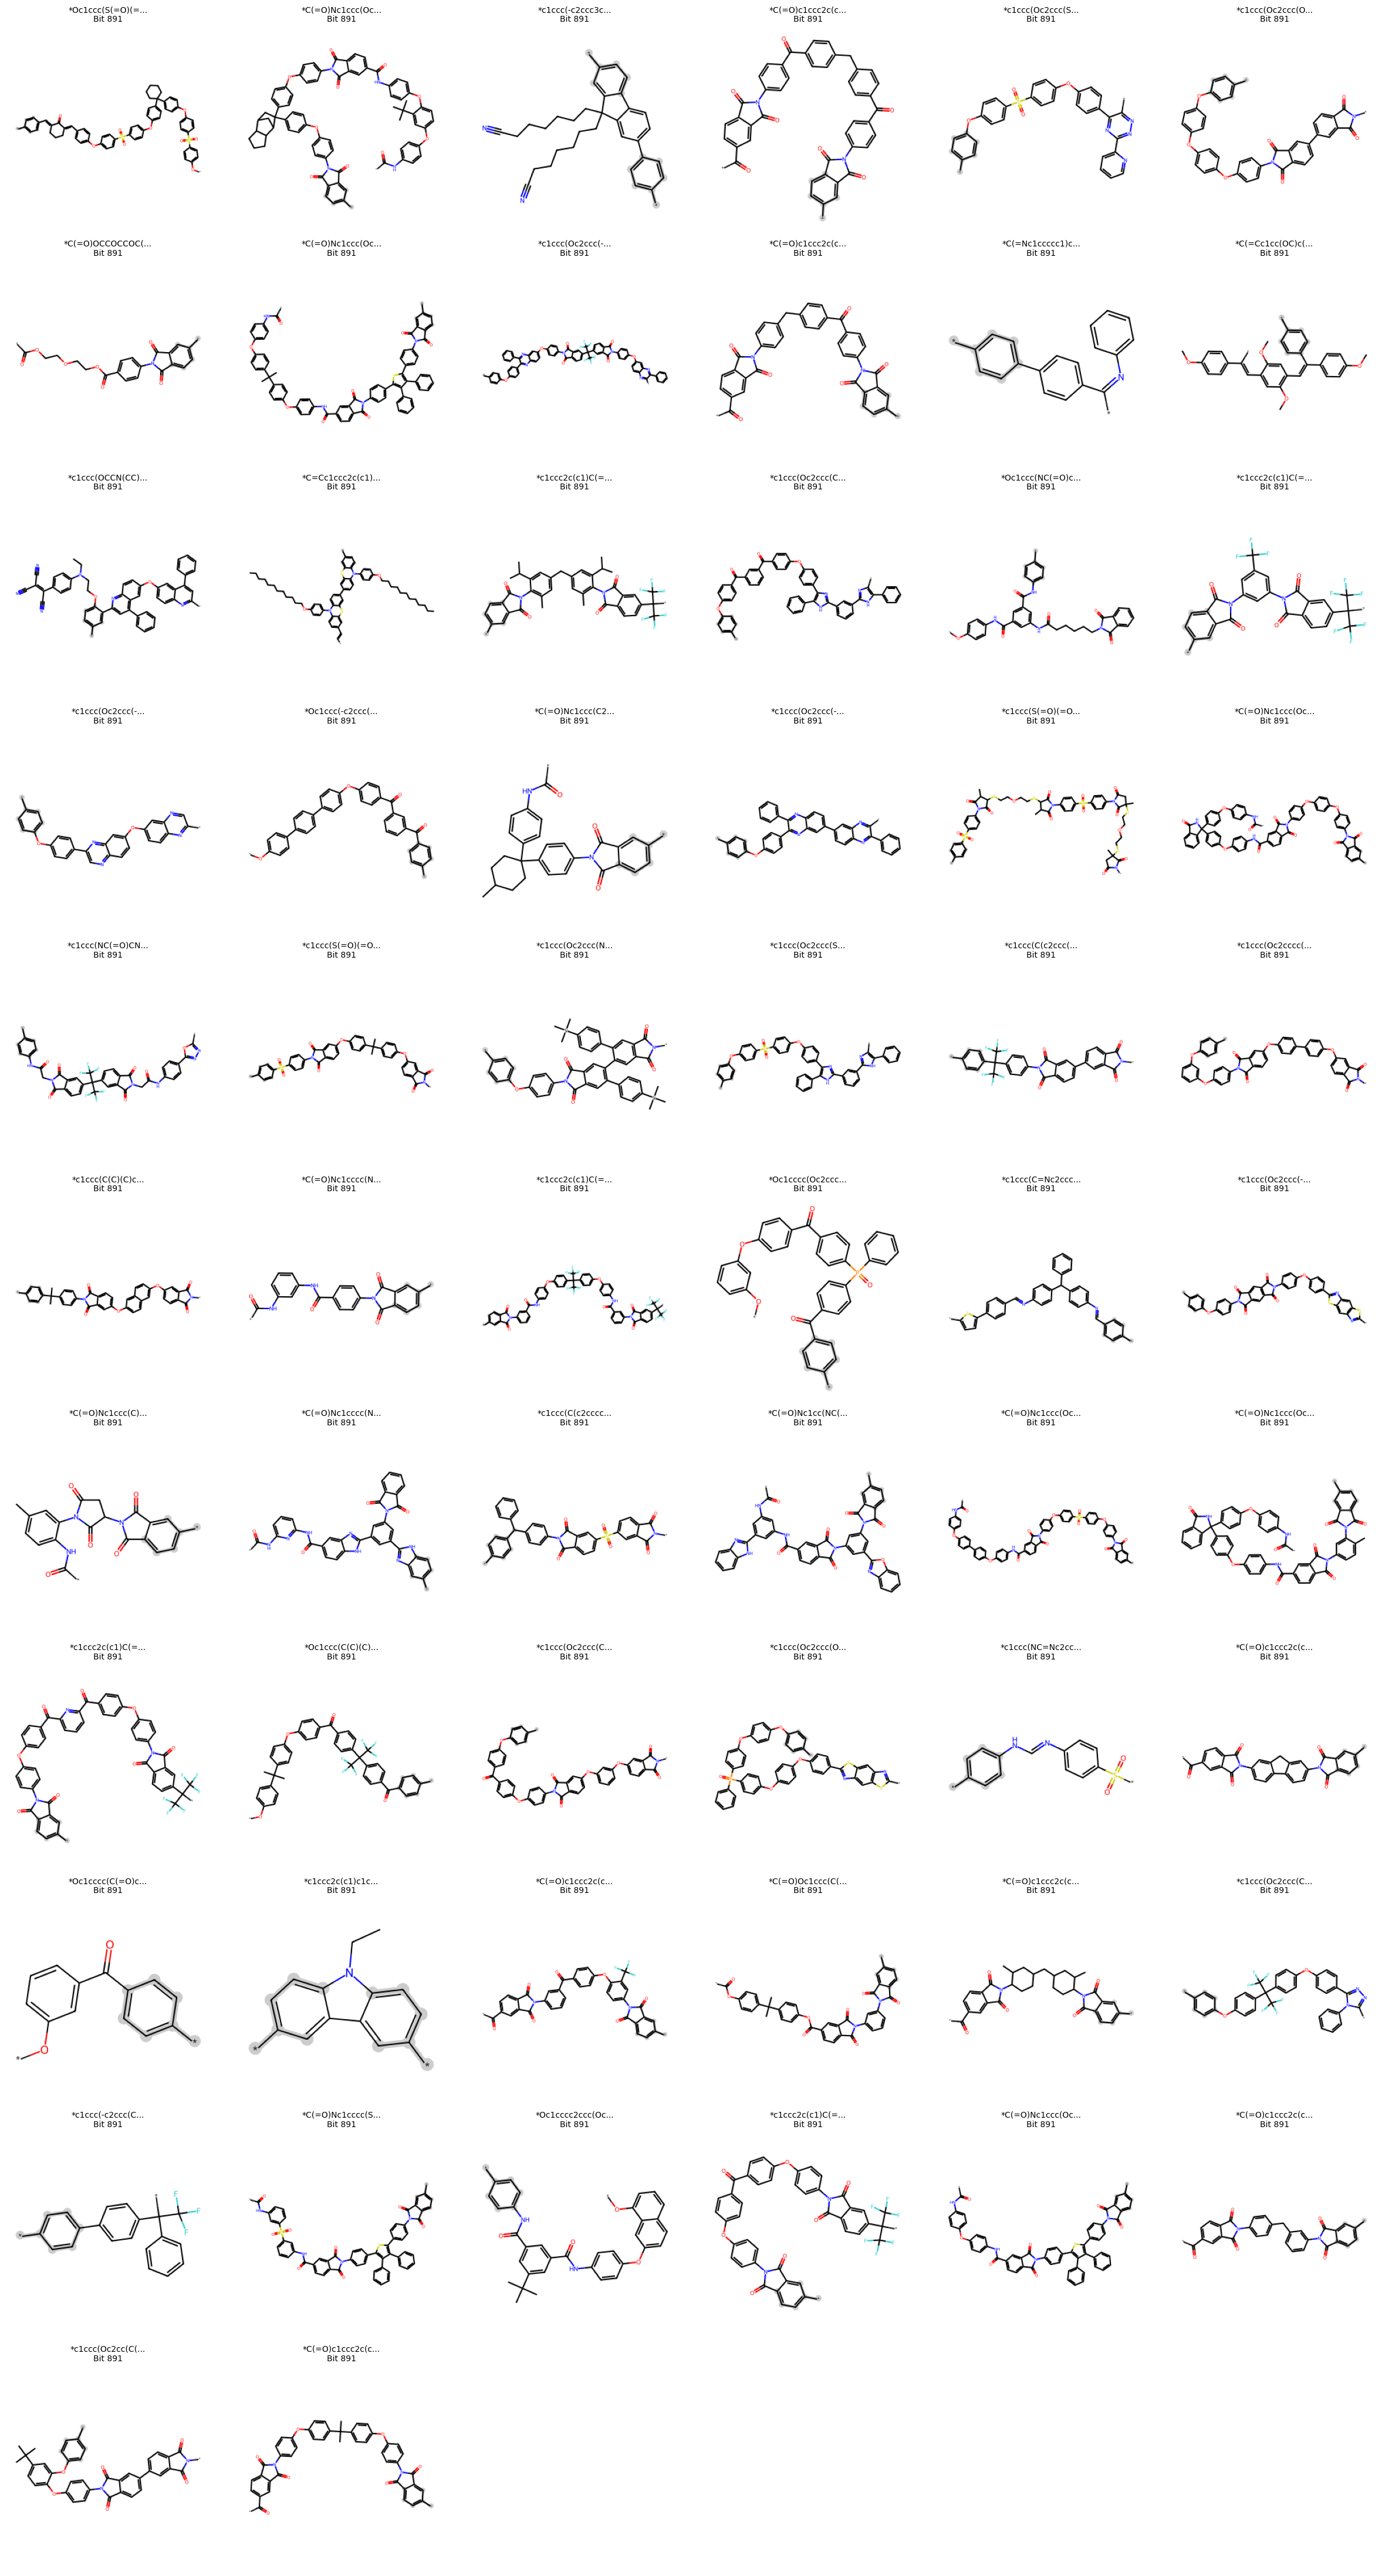

In [54]:
smiles_list = data["SMILES"].to_list()[:200]
visualize_bit_substructures(smiles_list, bit_position=891) #aromatic-*